In [1]:
# imports
import pandas as pd
import os, ipdb, re
import random, evaluate
import string
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from datasets import DatasetDict, Dataset, load_dataset
import wandb
import ast
import re, os
import subprocess

from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt

/nfs/home/kabenamualus/anaconda3/envs/tdm/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# # dataset_path = "../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_ALL_TEMPLATE/fold1"
# # dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_50_PERCENT/fold1"
# # dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_50_PERCENT_LONG/fold1"
# # dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_50_PERCENT_DOCTEAT/fold1"
# dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_NO_TEMPLATE_DOCTEAT/fold1"

# dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
    
# dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}

In [3]:
def calculate_fuzz_ratio(text1, text2):
    return fuzz.ratio(str(text1).strip().lower(), str(text2).strip().lower())

def view_leaderboard_distribution(dfs):
    dfs['train']['leaderboard'] = dfs['train'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    # Count unique values in the column
    counts_train = dfs['train']['leaderboard'].value_counts()

    # Plot pie chart
    plt.figure(figsize=(8, 8))  # Optional: Adjusts the size of the figure
    plt.pie(counts_train, labels=counts_train.index, autopct='%1.1f%%', startangle=140)
    plt.title('Train Leaderboard vs No Leaderboard')
    plt.show()
    
    dfs['validation']['leaderboard'] = dfs['validation'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    # Count unique values in the column
    counts_validation = dfs['validation']['leaderboard'].value_counts()

    # Plot pie chart
    plt.figure(figsize=(8, 8))  # Optional: Adjusts the size of the figure
    plt.pie(counts_validation, labels=counts_validation.index, autopct='%1.1f%%', startangle=140)
    plt.title('Validation Chart Leaderboard vs No Leaderboard')
    plt.show()
    
    dfs['zeroshot']['leaderboard'] = dfs['zeroshot'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    # Count unique values in the column
    counts = dfs['zeroshot']['leaderboard'].value_counts()

    # Plot pie chart
    plt.figure(figsize=(8, 8))  # Optional: Adjusts the size of the figure
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Zeroshot Chart Leaderboard vs No Leaderboard')
    plt.show()
    
    
def verify_data_integrity(dfs):

    zeroshot_paper_in_train = 0
    for paper in dfs['zeroshot'].id.unique():
        if paper in dfs['train'].id.to_list():
            zeroshot_paper_in_train += 1
        
    zeroshot_paper_in_validation = 0
    for paper in dfs['zeroshot'].id.unique():
        if paper in dfs['validation'].id.to_list():
            zeroshot_paper_in_validation += 1 

    train_paper_in_validation = 0
    for paper in dfs['train'].id.unique():
        if paper in dfs['validation'].id.to_list():
            train_paper_in_validation += 1   
        
    validation_paper_in_zeroshot = 0
    for paper in dfs['validation'].id.unique():
        if paper in dfs['zeroshot'].id.to_list():
            validation_paper_in_zeroshot += 1     
            
    print(f"zeroshot_paper_in_train: {zeroshot_paper_in_train}")
    print(f"zeroshot_paper_in_validation: {zeroshot_paper_in_validation}")
    print(f"train_paper_in_validation: {train_paper_in_validation}")
    print(f"validation_paper_in_zeroshot: {validation_paper_in_zeroshot}")
    
    
def remove_data_leakage_old(dfs, source, target, THRESHOLD=90):
    papers_to_drop = []
    missed_parsing_zero = 0
    
    dfs[source].drop_duplicates(subset='id', inplace=True)
    source_records = dfs[source].to_dict("records")

    for source_row in tqdm(source_records, total=len(source_records)):
        to_drop_paper_found = False 
        source_paper_id = source_row["id"]
        source_tdms = source_row["answer"]
        
        if source_tdms in "unanswerable" or source_tdms == "missed":
            # ipdb.set_trace()
            # if source_paper_id not in papers_to_drop:
            #     papers_to_drop.append(source_paper_id)
            continue 
        
        source_tdms = ast.literal_eval(source_row["answer"])
        
        for leaderboard_source in source_tdms:
            
            if to_drop_paper_found:
                break
            
            source_task = leaderboard_source["LEADERBOARD"]["Task"]
            source_dataset = leaderboard_source["LEADERBOARD"]["Dataset"]
            source_metric = leaderboard_source["LEADERBOARD"]["Metric"]
            source_score = leaderboard_source["LEADERBOARD"]["Score"]
 
            dfs[target].drop_duplicates(subset='id', inplace=True)
            
            target_records = dfs[target].to_dict("records")

            for target_row in target_records:
                
                if to_drop_paper_found:
                        break    
                
                target_paper_id = target_row["id"]
                target_tdms = target_row["answer"]
                
                if target_tdms == "unanswerable" or target_tdms == "missed":
                    # ipdb.set_trace()
                    continue 
                
                target_tdms = ast.literal_eval(target_row["answer"])
                
                
                for leaderboard_target in target_tdms:
                    target_task = leaderboard_target["LEADERBOARD"]["Task"]
                    target_dataset = leaderboard_target["LEADERBOARD"]["Dataset"]
                    target_metric = leaderboard_target["LEADERBOARD"]["Metric"]
                    target_score = leaderboard_target["LEADERBOARD"]["Score"]
                    
                    # A) Exact 
                    if (source_task == target_task and source_dataset == target_dataset and source_metric == target_metric) or (target_paper_id == source_paper_id):
                        if source_paper_id not in papers_to_drop:
                            papers_to_drop.append(source_paper_id)
                        to_drop_paper_found = True 
                        break
    
                    # # B) Partial  or # A) Exact 
                    # if (calculate_fuzz_ratio(train_task, zeroshot_task) >= THRESHOLD and calculate_fuzz_ratio(train_dataset, zeroshot_dataset) >= THRESHOLD and calculate_fuzz_ratio(train_metric, zeroshot_metric) >= THRESHOLD) or (train_task == zeroshot_task and train_dataset == zeroshot_dataset and train_metric == zeroshot_metric):
                    #     if paper_id not in papers_to_drop:
                    #         papers_to_drop.append(paper_id)
                    #         # ipdb.set_trace()
                    #         break 
                    
    print(f"Missed_parsing_zero {missed_parsing_zero}") 
    print(f"Lenght papers_to_drop in {source} based on {target}: {len(papers_to_drop)}")        
    
    return papers_to_drop


def remove_data_leakage_id(dfs, source, target, THRESHOLD=90):
    papers_to_drop = set()
    missed_parsing_zero = 0
    
    dfs[source].drop_duplicates(subset='id', inplace=True)
    records = dfs[source].to_dict("records")

    for row in tqdm(records, total=len(records)):
        to_drop_paper_found = False 
        source_paper_id = row["id"]
        
        dfs[target].drop_duplicates(subset='id', inplace=True)
        target_records = dfs[target].to_dict("records")

        for row_target in target_records:  
            
            target_paper_id = row_target["id"]
            
            # A) Exact 
            if (target_paper_id == source_paper_id):
                papers_to_drop.add(source_paper_id)
                to_drop_paper_found = True 
                break
                    
    print(f"Missed_parsing_zero {missed_parsing_zero}") 
    print(f"Lenght papers_to_drop in {source} based on {target}: {len(papers_to_drop)}")        
    
    return papers_to_drop


def remove_data_leakage(dfs, source, target, THRESHOLD=90):
    papers_to_drop = set()
    missed_parsing_zero = 0
    
    dfs[target].drop_duplicates(subset='id', inplace=True)
    unique_paper_id_target = dfs[target].id.unique()
    dfs[target]['lb']= dfs[target].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    lists_target = [ast.literal_eval(lb) for lb in dfs[target][dfs[target].lb =="lb"].answer.to_list()]
    # Flatten the list of lists
    flattened_list_target = [item for sublist in lists_target for item in sublist]
    # Extract unique tuples
    unique_tuples_target = {(d['LEADERBOARD']['Task'], d['LEADERBOARD']['Dataset'], d['LEADERBOARD']['Metric']) for d in flattened_list_target}


    dfs[source].drop_duplicates(subset='id', inplace=True)
    source_records = dfs[source].to_dict("records")
    for source_row in tqdm(source_records, total=len(source_records)):
        to_drop_paper_found = False 
        source_paper_id = source_row["id"]
        source_tdms = source_row["answer"]
        
        if source_paper_id in unique_paper_id_target:
            papers_to_drop.add(source_paper_id)
            continue     
        
        if source_tdms in "unanswerable" or source_tdms == "missed":
            # ipdb.set_trace()
            # if source_paper_id not in papers_to_drop:
            #     papers_to_drop.append(source_paper_id)
            continue 
        
        source_tdms = ast.literal_eval(source_row["answer"])
        # Extract unique tuples
        unique_tuples_source = {(d['LEADERBOARD']['Task'], d['LEADERBOARD']['Dataset'], d['LEADERBOARD']['Metric']) for d in source_tdms} 
        
        is_contained = unique_tuples_source.issubset(unique_tuples_target)
    
        if is_contained:
            papers_to_drop.add(source_paper_id)
            
      
        
        # # B) Partial  or # A) Exact 
        # if (calculate_fuzz_ratio(train_task, zeroshot_task) >= THRESHOLD and calculate_fuzz_ratio(train_dataset, zeroshot_dataset) >= THRESHOLD and calculate_fuzz_ratio(train_metric, zeroshot_metric) >= THRESHOLD) or (train_task == zeroshot_task and train_dataset == zeroshot_dataset and train_metric == zeroshot_metric):
        #     if paper_id not in papers_to_drop:
        #         papers_to_drop.append(paper_id)
        #         # ipdb.set_trace()
        #         break 
                    
    print(f"Missed_parsing_zero {missed_parsing_zero}") 
    print(f"Lenght papers_to_drop in {source} based on {target}: {len(papers_to_drop)}")        
    
    return papers_to_drop

# zeroshot_papers_to_drop_no_lb = remove_data_leakage_v2(dfs, source="zeroshot", target="train", THRESHOLD=90)


In [4]:
dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_ALL_TEMPLATE_DOCTEAT/fold1"

Docteat_dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
    
Docteat_dfs = {split: dataset.to_pandas() for split, dataset in Docteat_dataset_dict.items()}

Rec_dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_50_PERCENT/fold1"

Rec_dataset_dict = DatasetDict.load_from_disk(f"{Rec_dataset_path}")
    
Rec_dfs = {split: dataset.to_pandas() for split, dataset in Rec_dataset_dict.items()}

Long_dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_50_PERCENT_LONG/fold1"

Long_dataset_dict = DatasetDict.load_from_disk(f"{Long_dataset_path}")
    
Long_dfs = {split: dataset.to_pandas() for split, dataset in Long_dataset_dict.items()}

In [5]:
# dfs['train'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

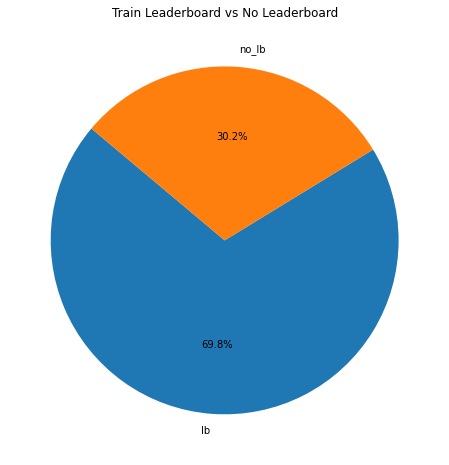

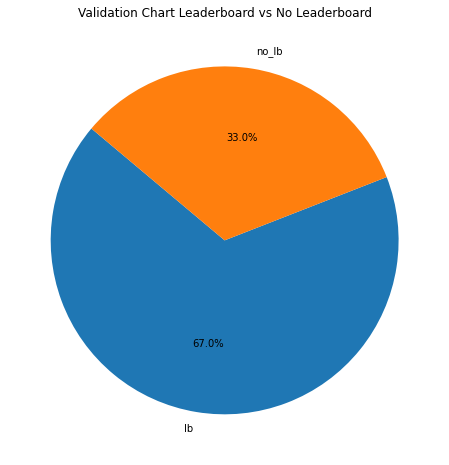

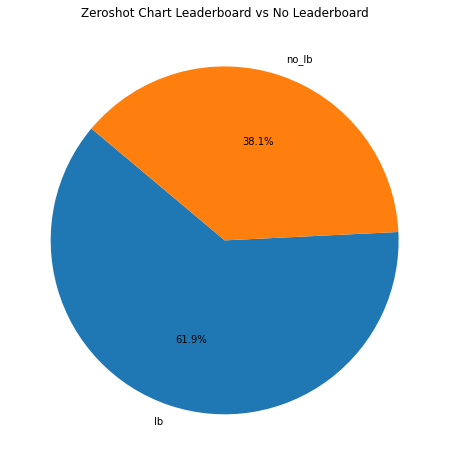

In [6]:
view_leaderboard_distribution(Docteat_dfs)

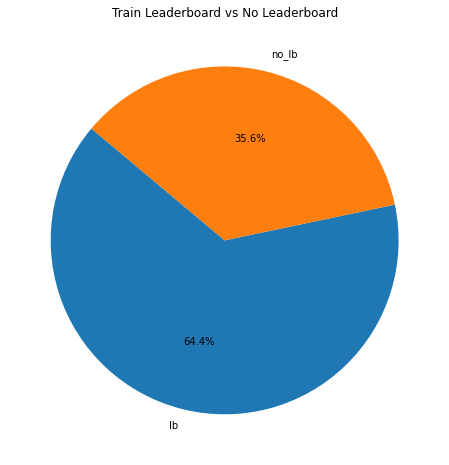

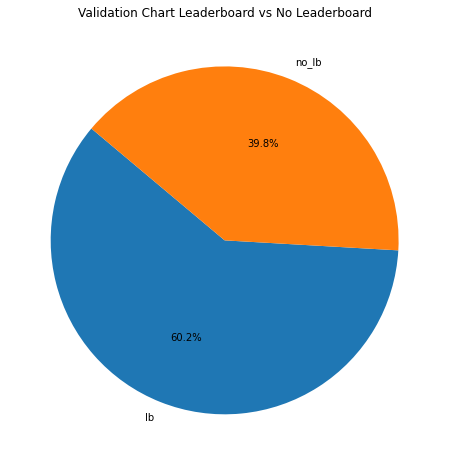

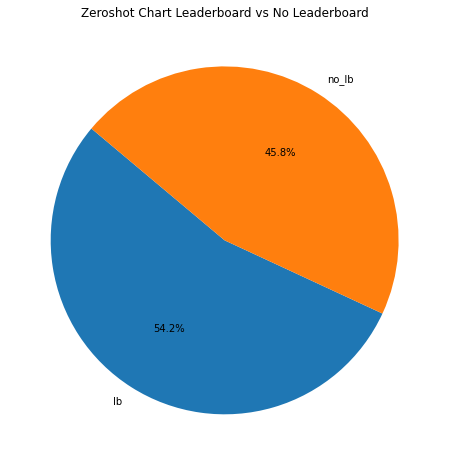

In [22]:
view_leaderboard_distribution(Rec_dfs)

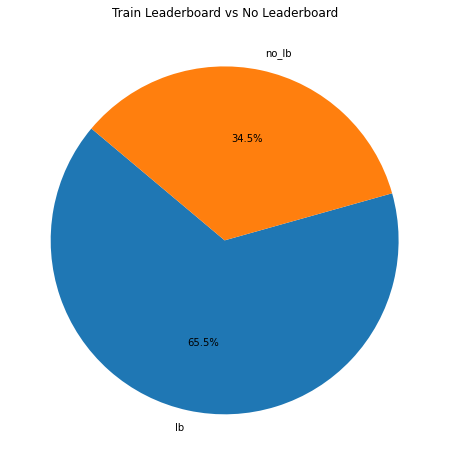

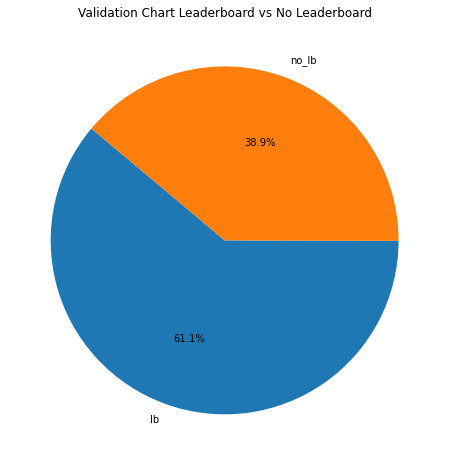

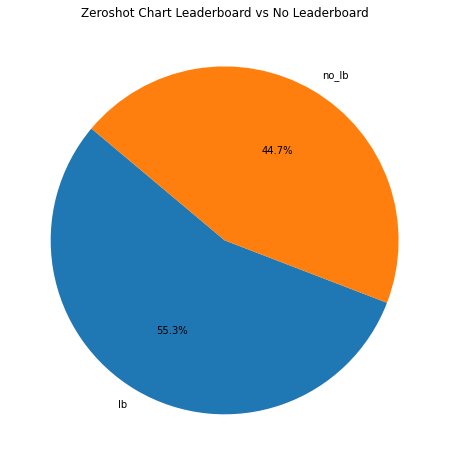

In [23]:
view_leaderboard_distribution(Long_dfs)

In [24]:
paper_in_train_validation = set(list(Docteat_dfs['train'].id.unique())+list(Docteat_dfs['validation'].id.unique())+list(Rec_dfs['train'].id.unique())+list(Rec_dfs['validation'].id.unique())+list(Long_dfs['train'].id.unique())+list(Long_dfs['validation'].id.unique()))

In [25]:
# This includes paper without leaderboard 
len(paper_in_train_validation)

14030

In [26]:
validation_papers_to_drop_no_lb = remove_data_leakage(Rec_dfs, source="validation", target="train", THRESHOLD=90)

100%|██████████| 1642/1642 [00:00<00:00, 5548.79it/s]

Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train: 753


In [14]:
# Filtering the DataFrame
Rec_dfs['validation'] = Rec_dfs['validation'][~Rec_dfs['validation']['id'].isin(validation_papers_to_drop_no_lb)]
Rec_dfs['validation'].drop_duplicates(subset='id', inplace=True)
Rec_dfs['validation'].describe()

,id,prompt,answer,template,leaderboard
count,889,889,889,889,889
unique,889,889,242,9,2
top,1508.01819v1.pdf,Title:\tSpectral Clustering and Block Models: ...,unanswerable,squad_1,no_lb
freq,1,1,648,424,648


In [16]:
len(Rec_dfs['validation'].id.unique())

889

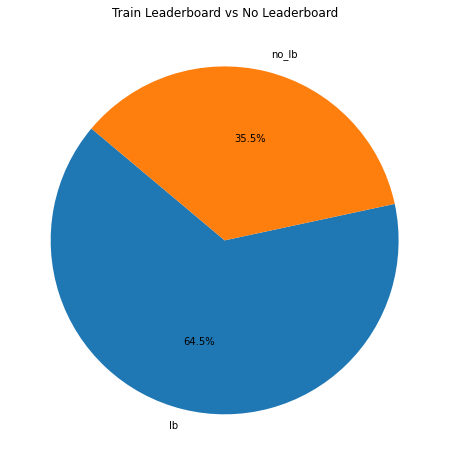

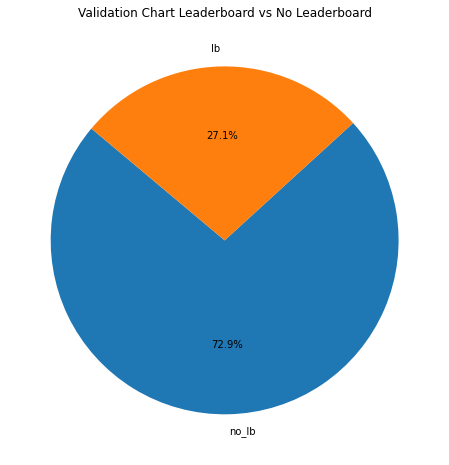

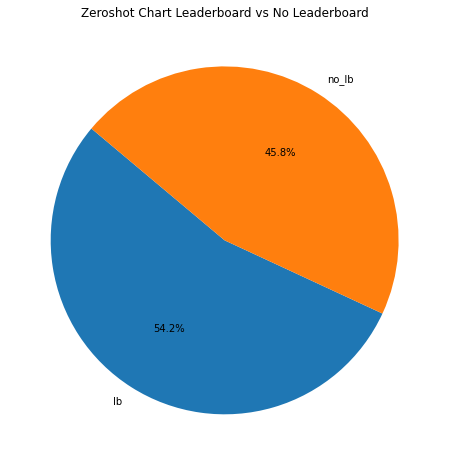

In [15]:
view_leaderboard_distribution(Rec_dfs)

In [27]:
Rec_dfs['validation'][Rec_dfs['validation']['id'].isin(validation_papers_to_drop_no_lb)]

,id,prompt,answer,template,leaderboard
0,1712.02047v1.pdf,Title:\tDistance-based Self-Attention Network ...,[{'LEADERBOARD': {'Task': 'Natural Language In...,squad_1,lb
7,1310.1757v2.pdf,Title:\t\n\nAbstract:\tThe Neural Autoregressi...,"[{'LEADERBOARD': {'Task': 'Image Generation', ...",squad_1,lb
8,1808.01340v1.pdf,Title:\tA Short Note about Kinetics-600\n\nAbs...,[{'LEADERBOARD': {'Task': 'Action Classificati...,squad_1,lb
10,2005.06734v2.pdf,Title:\tDense-Resolution Network for Point Clo...,[{'LEADERBOARD': {'Task': '3D Part Segmentatio...,squad_1,lb
12,1905.03704v1.pdf,Title:\tAgnostic Lane Detection\n\nAbstract:\t...,"[{'LEADERBOARD': {'Task': 'Lane Detection', 'D...",squad_1,lb
...,...,...,...,...,...
5688,1603.02754v3.pdf,Read this: Title:\tXGBoost: A Scalable Tree Bo...,"[{'LEADERBOARD': {'Task': 'Humor Detection', '...",squad_7,lb
6151,2006.00269v2.pdf,Read this: Title:\tIs Depth Really Necessary f...,[{'LEADERBOARD': {'Task': 'RGB-D Salient Objec...,squad_8,lb
7190,2009.07641v5.pdf,Answer based on context:\n\nTitle:\tBSN++: Com...,[{'LEADERBOARD': {'Task': 'Temporal Action Loc...,drop_1,lb
7673,1903.03096v4.pdf,Title:\tMeta-Dataset: A Dataset of Datasets fo...,[{'LEADERBOARD': {'Task': 'Few-Shot Image Clas...,drop_2,lb


In [ ]:
aaa

In [9]:
len(dfs['train'].id.unique())

10058

In [10]:
len(dfs['validation'].id.unique())

1347

In [11]:
len(dfs['zeroshot'].id.unique())

926

In [13]:
len(list(dfs['train'].id.unique())+list(dfs['validation'].id.unique())+list(dfs['zeroshot'].id.unique()))

12331

In [14]:
len(set(list(dfs['train'].id.unique())+list(dfs['validation'].id.unique())+list(dfs['zeroshot'].id.unique())))

11405

In [8]:
zeroshot_papers_to_drop_no_lb = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)

100%|██████████| 926/926 [09:11<00:00,  1.68it/s] 

Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


In [9]:
# validation_papers_to_drop_no_lb = remove_data_leakage(dfs, source="validation", target="zeroshot", THRESHOLD=90)

dfs['zeroshot'].drop_duplicates(subset='id', inplace=True)
records = dfs['zeroshot'].to_dict("records")
validation_papers_to_drop_no_lb = set()
for row in tqdm(records, total=len(records)):
    # if row['id'] in dfs['train']['id'].to_list():
    #     duplicate+=1
    if row['id'] in dfs['validation']['id'].to_list():
        validation_papers_to_drop_no_lb.add(row['id'])
        
print(len(validation_papers_to_drop_no_lb))

100%|██████████| 926/926 [00:00<00:00, 6354.35it/s]

408


In [10]:
# Filtering the DataFrame
dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop_no_lb)]
dfs['zeroshot'].drop_duplicates(subset='id', inplace=True)
dfs['zeroshot'].describe()

,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,197.560907,11235.00000
std,99.668184,1530.69837
min,29.000000,8595.00000
25%,138.000000,9915.00000
50%,192.000000,11235.00000
75%,234.000000,12555.00000
max,677.000000,13875.00000


In [11]:
# Filtering the DataFrame
dfs['validation'] = dfs['validation'][~dfs['validation']['id'].isin(validation_papers_to_drop_no_lb)]
dfs['validation'].drop_duplicates(subset='id', inplace=True)
dfs['validation'].describe()

,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,568.654952,7434.408946
std,358.102912,4300.934395
min,26.000000,0.000000
25%,325.000000,3712.500000
50%,497.000000,7425.000000
75%,707.500000,11137.500000
max,3431.000000,14895.000000


In [12]:
# Filtering the DataFrame
dfs['train'].drop_duplicates(subset='id', inplace=True)
dfs['train'].describe()

,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,485.707298,75427.500000
std,398.739365,43554.582566
min,27.000000,0.000000
25%,216.000000,37713.750000
50%,392.000000,75427.500000
75%,640.000000,113141.250000
max,7344.000000,150855.000000


In [13]:
dfs['train'].drop(["template", "__index_level_0__"], inplace=True, axis=1)
dfs['validation'].drop(["template", "__index_level_0__"], inplace=True, axis=1)
dfs['zeroshot'].drop(["template", "__index_level_0__"], inplace=True, axis=1)

In [14]:
dfs['train'].tail()

,id,prompt,answer,prompt lenght
150795,1401.6576.pdf,Adding modular predicates to first-order fragm...,unanswerable,206
150810,1304.4691.pdf,Efficient Calculation of Determinants of Symbo...,unanswerable,128
150825,1001.3388.pdf,Approximate Privacy: PARs for Set Problems In ...,unanswerable,183
150840,0706.2010.pdf,Information-theoretic securitywithout an hones...,unanswerable,131
150855,1111.2942.pdf,Down the Rabbit Hole: Robust Proximity Search ...,unanswerable,232


In [15]:
dfs['train'].id.nunique()

10058

In [16]:
def verify_data_integrity(dfs):

    zeroshot_paper_in_train = 0
    for paper in dfs['zeroshot'].id.unique():
        if paper in dfs['train'].id.to_list():
            zeroshot_paper_in_train += 1
        
    zeroshot_paper_in_validation = 0
    for paper in dfs['zeroshot'].id.unique():
        if paper in dfs['validation'].id.to_list():
            zeroshot_paper_in_validation += 1 

    train_paper_in_validation = 0
    for paper in dfs['train'].id.unique():
        if paper in dfs['validation'].id.to_list():
            train_paper_in_validation += 1   
        
    validation_paper_in_zeroshot = 0
    for paper in dfs['validation'].id.unique():
        if paper in dfs['zeroshot'].id.to_list():
            validation_paper_in_zeroshot += 1     
            
    print(f"zeroshot_paper_in_train: {zeroshot_paper_in_train}")
    print(f"zeroshot_paper_in_validation: {zeroshot_paper_in_validation}")
    print(f"train_paper_in_validation: {train_paper_in_validation}")
    print(f"validation_paper_in_zeroshot: {validation_paper_in_zeroshot}")

In [17]:
verify_data_integrity(dfs)

zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


In [18]:
dataset = DatasetDict({
        "train": Dataset.from_pandas(dfs['train']),
        "validation": Dataset.from_pandas(dfs['validation']),
        "zeroshot": Dataset.from_pandas(dfs['zeroshot'])
    })

dataset.save_to_disk("../data/LEADERBOARDS_DOCTEAT_TDMS_NO_TEMPLATES_STRICT")

Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

### Template Specific

In [19]:
for squad_id in range(1, 9):
    print(f"SQUAD: {squad_id}")
    dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_SQUAD_{squad_id}_DOCTEAT/fold1"

    dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
        
    dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}
    
    zeroshot_papers_to_drop_no_lb = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
    
    dfs['zeroshot'].drop_duplicates(subset='id', inplace=True)
    records = dfs['zeroshot'].to_dict("records")
    validation_papers_to_drop_no_lb = set()
    for row in tqdm(records, total=len(records)):
        # if row['id'] in dfs['train']['id'].to_list():
        #     duplicate+=1
        if row['id'] in dfs['validation']['id'].to_list():
            validation_papers_to_drop_no_lb.add(row['id'])
            
    print(len(validation_papers_to_drop_no_lb))
    
    # Filtering the DataFrame
    dfs['train'].drop_duplicates(subset='id', inplace=True)
    display(dfs['train'].describe())

    # Filtering the DataFrame
    dfs['validation'] = dfs['validation'][~dfs['validation']['id'].isin(validation_papers_to_drop_no_lb)]
    dfs['validation'].drop_duplicates(subset='id', inplace=True)
    display(dfs['validation'].describe())

    # Filtering the DataFrame
    dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop_no_lb)]
    dfs['zeroshot'].drop_duplicates(subset='id', inplace=True)
    display(dfs['zeroshot'].describe())
    
    dfs['train'].drop(["template", "__index_level_0__"], inplace=True, axis=1)
    dfs['validation'].drop(["template", "__index_level_0__"], inplace=True, axis=1)
    dfs['zeroshot'].drop(["template", "__index_level_0__"], inplace=True, axis=1)

    verify_data_integrity(dfs)
    
    dataset = DatasetDict({
        "train": Dataset.from_pandas(dfs['train']),
        "validation": Dataset.from_pandas(dfs['validation']),
        "zeroshot": Dataset.from_pandas(dfs['zeroshot'])
    })

    dataset.save_to_disk(f"../data/LEADERBOARDS_DOCTEAT_TDMS_NO_TEMPLATES_SQUAD_{squad_id}_STRICT")

SQUAD: 1


  0%|          | 0/926 [00:00<?, ?it/s]

 28%|██▊       | 262/926 [05:04<10:02,  1.10it/s] 

In [ ]:
for drop_id in range(1, 8):
    print(f"DROP: {drop_id}")
    dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_DROP_{drop_id}_DOCTEAT/fold1"

    dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
        
    dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}
    
    zeroshot_papers_to_drop_no_lb = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
    
    dfs['zeroshot'].drop_duplicates(subset='id', inplace=True)
    records = dfs['zeroshot'].to_dict("records")
    validation_papers_to_drop_no_lb = set()
    for row in tqdm(records, total=len(records)):
        # if row['id'] in dfs['train']['id'].to_list():
        #     duplicate+=1
        if row['id'] in dfs['validation']['id'].to_list():
            validation_papers_to_drop_no_lb.add(row['id'])
            
    print(len(validation_papers_to_drop_no_lb))
    
    # Filtering the DataFrame
    dfs['train'].drop_duplicates(subset='id', inplace=True)
    display(dfs['train'].describe())

    # Filtering the DataFrame
    dfs['validation'] = dfs['validation'][~dfs['validation']['id'].isin(validation_papers_to_drop_no_lb)]
    dfs['validation'].drop_duplicates(subset='id', inplace=True)
    display(dfs['validation'].describe())

    # Filtering the DataFrame
    dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop_no_lb)]
    dfs['zeroshot'].drop_duplicates(subset='id', inplace=True)
    display(dfs['zeroshot'].describe())
    
    dfs['train'].drop(["template", "__index_level_0__"], inplace=True, axis=1)
    dfs['validation'].drop(["template", "__index_level_0__"], inplace=True, axis=1)
    dfs['zeroshot'].drop(["template", "__index_level_0__"], inplace=True, axis=1)

    verify_data_integrity(dfs)
    
    dataset = DatasetDict({
        "train": Dataset.from_pandas(dfs['train']),
        "validation": Dataset.from_pandas(dfs['validation']),
        "zeroshot": Dataset.from_pandas(dfs['zeroshot'])
    })

    dataset.save_to_disk(f"../data/LEADERBOARDS_DOCTEAT_TDMS_NO_TEMPLATES_DROP_{drop_id}_STRICT")

100%|██████████| 926/926 [09:08<00:00,  1.69it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 75687.92it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,488.707298,75435.500000
std,398.739365,43554.582566
min,30.000000,8.000000
25%,219.000000,37721.750000
50%,395.000000,75435.500000
75%,643.000000,113149.250000
max,7347.000000,150863.000000


,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,571.654952,7442.408946
std,358.102912,4300.934395
min,29.000000,8.000000
25%,328.000000,3720.500000
50%,500.000000,7433.000000
75%,710.500000,11145.500000
max,3434.000000,14903.000000


,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,200.560907,11243.00000
std,99.668184,1530.69837
min,32.000000,8603.00000
25%,141.000000,9923.00000
50%,195.000000,11243.00000
75%,237.000000,12563.00000
max,680.000000,13883.00000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

100%|██████████| 926/926 [09:10<00:00,  1.68it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 77613.31it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,491.707298,75436.500000
std,398.739365,43554.582566
min,33.000000,9.000000
25%,222.000000,37722.750000
50%,398.000000,75436.500000
75%,646.000000,113150.250000
max,7350.000000,150864.000000


,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,574.654952,7443.408946
std,358.102912,4300.934395
min,32.000000,9.000000
25%,331.000000,3721.500000
50%,503.000000,7434.000000
75%,713.500000,11146.500000
max,3437.000000,14904.000000


,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,203.560907,11244.00000
std,99.668184,1530.69837
min,35.000000,8604.00000
25%,144.000000,9924.00000
50%,198.000000,11244.00000
75%,240.000000,12564.00000
max,683.000000,13884.00000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

100%|██████████| 924/924 [09:12<00:00,  1.67it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 572


100%|██████████| 924/924 [00:00<00:00, 75726.62it/s]

407


,prompt lenght,__index_level_0__
count,10051.000000,10051.000000
mean,484.701622,75455.098995
std,398.858367,43559.044436
min,26.000000,10.000000
25%,215.000000,37742.500000
50%,391.000000,75475.000000
75%,639.500000,113177.500000
max,7343.000000,150865.000000


,prompt lenght,__index_level_0__
count,937.000000,937.000000
mean,567.586980,7445.021345
std,358.481939,4304.324351
min,25.000000,10.000000
25%,324.000000,3715.000000
50%,495.000000,7435.000000
75%,708.000000,11155.000000
max,3430.000000,14905.000000


,prompt lenght,__index_level_0__
count,352.000000,352.000000
mean,196.417614,11240.951705
std,99.773641,1530.983713
min,28.000000,8605.000000
25%,137.000000,9921.250000
50%,191.000000,11237.500000
75%,233.000000,12553.750000
max,676.000000,13885.000000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10051 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/937 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/352 [00:00<?, ? examples/s]

100%|██████████| 926/926 [09:13<00:00,  1.67it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 76326.01it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,487.707298,75438.500000
std,398.739365,43554.582566
min,29.000000,11.000000
25%,218.000000,37724.750000
50%,394.000000,75438.500000
75%,642.000000,113152.250000
max,7346.000000,150866.000000


,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,570.654952,7445.408946
std,358.102912,4300.934395
min,28.000000,11.000000
25%,327.000000,3723.500000
50%,499.000000,7436.000000
75%,709.500000,11148.500000
max,3433.000000,14906.000000


,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,199.560907,11246.00000
std,99.668184,1530.69837
min,31.000000,8606.00000
25%,140.000000,9926.00000
50%,194.000000,11246.00000
75%,236.000000,12566.00000
max,679.000000,13886.00000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

100%|██████████| 926/926 [09:11<00:00,  1.68it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 77192.20it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,491.707298,75439.500000
std,398.739365,43554.582566
min,33.000000,12.000000
25%,222.000000,37725.750000
50%,398.000000,75439.500000
75%,646.000000,113153.250000
max,7350.000000,150867.000000


,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,574.654952,7446.408946
std,358.102912,4300.934395
min,32.000000,12.000000
25%,331.000000,3724.500000
50%,503.000000,7437.000000
75%,713.500000,11149.500000
max,3437.000000,14907.000000


,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,203.560907,11247.00000
std,99.668184,1530.69837
min,35.000000,8607.00000
25%,144.000000,9927.00000
50%,198.000000,11247.00000
75%,240.000000,12567.00000
max,683.000000,13887.00000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

100%|██████████| 926/926 [09:12<00:00,  1.68it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 76809.03it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,492.707298,75440.500000
std,398.739365,43554.582566
min,34.000000,13.000000
25%,223.000000,37726.750000
50%,399.000000,75440.500000
75%,647.000000,113154.250000
max,7351.000000,150868.000000


,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,575.654952,7447.408946
std,358.102912,4300.934395
min,33.000000,13.000000
25%,332.000000,3725.500000
50%,504.000000,7438.000000
75%,714.500000,11150.500000
max,3438.000000,14908.000000


,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,204.560907,11248.00000
std,99.668184,1530.69837
min,36.000000,8608.00000
25%,145.000000,9928.00000
50%,199.000000,11248.00000
75%,241.000000,12568.00000
max,684.000000,13888.00000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

100%|██████████| 926/926 [09:11<00:00,  1.68it/s] 


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train: 573


100%|██████████| 926/926 [00:00<00:00, 78289.17it/s]

408


,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,487.707298,75441.497216
std,398.739365,43554.584181
min,29.000000,14.000000
25%,218.000000,37727.750000
50%,394.000000,75441.500000
75%,642.000000,113155.250000
max,7346.000000,150869.000000


,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,570.654952,7448.400426
std,358.102912,4300.934968
min,28.000000,14.000000
25%,327.000000,3726.500000
50%,499.000000,7439.000000
75%,709.500000,11151.500000
max,3433.000000,14909.000000


,prompt lenght,__index_level_0__
count,353.000000,353.000000
mean,199.560907,11248.988669
std,99.668184,1530.687806
min,31.000000,8609.000000
25%,140.000000,9929.000000
50%,194.000000,11249.000000
75%,236.000000,12569.000000
max,679.000000,13889.000000


zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

## DOCTEAT

### RELAX

In [ ]:
dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_NO_TEMPLATE_DOCTEAT/fold1"

dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
    
dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}

In [ ]:
dfs['train'].describe()

,prompt lenght,__index_level_0__
count,150870.000000,150870.000000
mean,485.707298,75434.500000
std,398.720864,43552.561894
min,27.000000,0.000000
25%,216.000000,37717.250000
50%,392.000000,75434.500000
75%,640.000000,113151.750000
max,7344.000000,150869.000000


In [ ]:
dfs['validation'].describe()

,prompt lenght,__index_level_0__
count,20205.000000,20205.00000
mean,473.135857,10102.00000
std,352.229574,5832.82543
min,26.000000,0.00000
25%,222.000000,5051.00000
50%,387.000000,10102.00000
75%,614.000000,15153.00000
max,3431.000000,20204.00000


In [ ]:
dfs['zeroshot'].describe()

,prompt lenght,__index_level_0__
count,13890.000000,13890.000000
mean,444.615551,6944.500000
std,405.101173,4009.841954
min,29.000000,0.000000
25%,199.000000,3472.250000
50%,342.000000,6944.500000
75%,582.000000,10416.750000
max,7344.000000,13889.000000


In [ ]:
zeroshot_papers_to_drop_no_lb = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)

 35%|███▌      | 328/926 [06:04<04:14,  2.35it/s] 

In [ ]:
# validation_papers_to_drop_no_lb = remove_data_leakage(dfs, source="validation", target="zeroshot", THRESHOLD=90)

records = dfs['zeroshot'].to_dict("records")
validation_papers_to_drop_no_lb = set()
for row in tqdm(records, total=len(records)):
    # if row['id'] in dfs['train']['id'].to_list():
    #     duplicate+=1
    if row['id'] in dfs['validation']['id'].to_list():
        validation_papers_to_drop_no_lb.add(row['id'])
        
print(len(validation_papers_to_drop_no_lb))

100%|██████████| 926/926 [00:00<00:00, 6443.53it/s]

408


In [ ]:
# Filtering the DataFrame
dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop_no_lb)]
dfs['zeroshot'].describe()

,prompt lenght,__index_level_0__
count,353.000000,353.00000
mean,197.560907,11235.00000
std,99.668184,1530.69837
min,29.000000,8595.00000
25%,138.000000,9915.00000
50%,192.000000,11235.00000
75%,234.000000,12555.00000
max,677.000000,13875.00000


In [ ]:
# Filtering the DataFrame
dfs['validation'] = dfs['validation'][~dfs['validation']['id'].isin(validation_papers_to_drop_no_lb)]
dfs['validation'].describe()

,prompt lenght,__index_level_0__
count,939.000000,939.000000
mean,568.654952,7434.408946
std,358.102912,4300.934395
min,26.000000,0.000000
25%,325.000000,3712.500000
50%,497.000000,7425.000000
75%,707.500000,11137.500000
max,3431.000000,14895.000000


In [ ]:
# Filtering the DataFrame
dfs['train'].describe()

,prompt lenght,__index_level_0__
count,10058.000000,10058.000000
mean,485.707298,75427.500000
std,398.739365,43554.582566
min,27.000000,0.000000
25%,216.000000,37713.750000
50%,392.000000,75427.500000
75%,640.000000,113141.250000
max,7344.000000,150855.000000


In [ ]:
dfs['train'].drop(["template", "__index_level_0__"], inplace=True, axis=1)
dfs['validation'].drop(["template", "__index_level_0__"], inplace=True, axis=1)
dfs['zeroshot'].drop(["template", "__index_level_0__"], inplace=True, axis=1)

In [ ]:
dfs['train'].tail()

,id,prompt,answer,prompt lenght
150795,1401.6576.pdf,Adding modular predicates to first-order fragm...,unanswerable,206
150810,1304.4691.pdf,Efficient Calculation of Determinants of Symbo...,unanswerable,128
150825,1001.3388.pdf,Approximate Privacy: PARs for Set Problems In ...,unanswerable,183
150840,0706.2010.pdf,Information-theoretic securitywithout an hones...,unanswerable,131
150855,1111.2942.pdf,Down the Rabbit Hole: Robust Proximity Search ...,unanswerable,232


In [ ]:
dfs['train'].id.nunique()

10058

In [ ]:
verify_data_integrity(dfs)

zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
train_paper_in_validation: 0
validation_paper_in_zeroshot: 0


In [ ]:
dataset = DatasetDict({
        "train": Dataset.from_pandas(dfs['train']),
        "validation": Dataset.from_pandas(dfs['validation']),
        "zeroshot": Dataset.from_pandas(dfs['zeroshot'])
    })

dataset.save_to_disk("../data/LEADERBOARDS_DOCTEAT_TDMS_NO_TEMPLATES_RELAX")

Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/939 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/353 [00:00<?, ? examples/s]

### Templates Specific

In [ ]:
for squad_id in range(1, 9):
    print(f"SQUAD: {squad_id}")
    dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_SQUAD_{squad_id}_DOCTEAT/fold1"

    dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
        
    dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}
    
    zeroshot_papers_to_drop_no_lb = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
    
    records = dfs['zeroshot'].to_dict("records")
    validation_papers_to_drop_no_lb = set()
    for row in tqdm(records, total=len(records)):
        # if row['id'] in dfs['train']['id'].to_list():
        #     duplicate+=1
        if row['id'] in dfs['validation']['id'].to_list():
            validation_papers_to_drop_no_lb.add(row['id'])
            
    print(len(validation_papers_to_drop_no_lb))
    
    # Filtering the DataFrame
    display(dfs['train'].describe())

    # Filtering the DataFrame
    dfs['validation'] = dfs['validation'][~dfs['validation']['id'].isin(validation_papers_to_drop_no_lb)]
    display(dfs['validation'].describe())

    # Filtering the DataFrame
    dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop_no_lb)]
    display(dfs['zeroshot'].describe())
    
    dfs['train'].drop(["template", "__index_level_0__"], inplace=True, axis=1)
    dfs['validation'].drop(["template", "__index_level_0__"], inplace=True, axis=1)
    dfs['zeroshot'].drop(["template", "__index_level_0__"], inplace=True, axis=1)

    verify_data_integrity(dfs)
    
    dataset = DatasetDict({
        "train": Dataset.from_pandas(dfs['train']),
        "validation": Dataset.from_pandas(dfs['validation']),
        "zeroshot": Dataset.from_pandas(dfs['zeroshot'])
    })

    dataset.save_to_disk(f"../data/LEADERBOARDS_DOCTEAT_TDMS_NO_TEMPLATES_SQUAD_{squad_id}_RELAX")

100%|██████████| 926/926 [09:07<00:00,  1.69it/s] 


In [ ]:
for drop_id in range(1, 8):
    print(f"DROP: {drop_id}")
    dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_DROP_{drop_id}_DOCTEAT/fold1"

    dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
        
    dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}
    
    zeroshot_papers_to_drop_no_lb = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
    
    dfs['zeroshot'].drop_duplicates(subset='id', inplace=True)
    records = dfs['zeroshot'].to_dict("records")
    validation_papers_to_drop_no_lb = set()
    for row in tqdm(records, total=len(records)):
        # if row['id'] in dfs['train']['id'].to_list():
        #     duplicate+=1
        if row['id'] in dfs['validation']['id'].to_list():
            validation_papers_to_drop_no_lb.add(row['id'])
            
    print(len(validation_papers_to_drop_no_lb))
    
    # Filtering the DataFrame
    display(dfs['train'].describe())

    # Filtering the DataFrame
    dfs['validation'] = dfs['validation'][~dfs['validation']['id'].isin(validation_papers_to_drop_no_lb)]
    display(dfs['validation'].describe())

    # Filtering the DataFrame
    dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop_no_lb)]
    display(dfs['zeroshot'].describe())
    
    dfs['train'].drop(["template", "__index_level_0__"], inplace=True, axis=1)
    dfs['validation'].drop(["template", "__index_level_0__"], inplace=True, axis=1)
    dfs['zeroshot'].drop(["template", "__index_level_0__"], inplace=True, axis=1)

    verify_data_integrity(dfs)
    
    dataset = DatasetDict({
        "train": Dataset.from_pandas(dfs['train']),
        "validation": Dataset.from_pandas(dfs['validation']),
        "zeroshot": Dataset.from_pandas(dfs['zeroshot'])
    })

    dataset.save_to_disk(f"../data/LEADERBOARDS_DOCTEAT_TDMS_NO_TEMPLATES_DROP_{drop_id}_RELAX")